In [2]:
%run _init_notebook.ipynb
import os
import matplotlib.gridspec as gridspec
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.profiler
from approxmh.vae import ConvVAE
from approxmh.model_trainers import AdaptiveVAETrainer, AdaptiveFlowTrainer
from approxmh.distributions import create_serpentine, create_random_gaussian_mixture, IndependentMultivariateNormal, Funnel, PoorlyConditionedGaussian
from approxmh.samplers import AdaptiveVAESampler, MetropolisHastingsFilter, VAEGlobalMHFilter, VAEMetropolisWithinGibbsSampler
from approxmh.utilities import visualize_distribution
from approxmh.likelihood_estimators import SISLikelihoodEstimator, IWLikelihoodEstimator
from approxmh.y_utils import *
from approxmh.distribution_metrics import CoordinateDistributionMetric, TotalVariation1d
from approxmh.rnvp import RNVP
from approxmh.pyro_samplers import NUTS
from approxmh.utilities import count_parameters, dataloader_from_tensor
from approxmh.ebm_distributions import MnistEBMDistribution

device: cuda


C:\Users\YS\science\mcmc_research_project\mcmc_venv_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\YS\AppData\Local\Temp\ipykernel_22564\871397608.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.tensor = torch.load(savefile)


torch.Size([5, 1, 28, 28])
Device of images batch: cpu
Shape of images batch: torch.Size([128, 1, 28, 28])


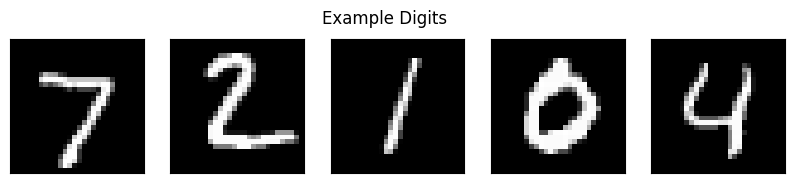

In [9]:
DATASET_DIR = '../datasets/'


class FastDataLoader:
    def __init__(self, tensor, batch_size=1, pin_memory=False, shuffle=False):
        self.dataset = tensor
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.len = tensor.shape[0]
        self.n_batches = (self.len - 1) // self.batch_size + 1
        self.index = None

    def __iter__(self):
        if self.shuffle:
            self.dataset = self.dataset[torch.randperm(self.len)]
        self.index = 0
        return self

    def __next__(self):
        if self.index == self.len:
            raise StopIteration
        next_index = min(self.len, self.index + self.batch_size)
        result = self.dataset[self.index : next_index]
        self.index = next_index
        return result

    def __len__(self):
        return self.n_batches



class PreprocessedUnlabeledDataset:
    def __init__(self, original_dataset, savefile=None):
        if os.path.exists(savefile):
            self.tensor = torch.load(savefile)
            return
        elements = []
        for x, y in original_dataset:
            elements.append(x)
        self.tensor = torch.stack(elements)
        if savefile is not None:
            torch.save(self.tensor, savefile)

    def __getitem__(self, i):
        return self.tensor[i]

    def __len__(self):
        return self.tensor.shape[0]


def preprocessed_unlabeled_tensor(original_dataset, savefile=None, shuffle=False):
    if os.path.exists(savefile):
        return torch.load(savefile)
    elements = []
    for x, y in original_dataset:
        elements.append(x)
    result = torch.stack(elements)[torch.randperm(len(elements))]
    if savefile is not None:
        torch.save(result, savefile)
    return result


# im_sz = 32  # because this is how the EBM was trained
transform = transforms.Compose([
#    transforms.Resize(im_sz),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5 and std 0.5
])

train_dataset = datasets.MNIST(root=DATASET_DIR, train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root=DATASET_DIR, train=False, download=True, transform=transform)
train_dataset = PreprocessedUnlabeledDataset(train_dataset, DATASET_DIR + 'mnist_train_preprocessed.pth')
val_dataset = PreprocessedUnlabeledDataset(val_dataset, DATASET_DIR + 'mnist_val_preprocessed.pth')

# Create dataloaders for training and testing datasets
train_loader = FastDataLoader(train_dataset.tensor, batch_size=128, shuffle=True)
val_loader = FastDataLoader(val_dataset.tensor, batch_size=8192, shuffle=False)

# Images to show and to test reconstruction quality
n_display_imgs = 5
display_imgs = torch.stack([val_dataset[i] for i in range(n_display_imgs)])
print(display_imgs.shape)

fig, axs = plt.subplots(ncols=5, figsize=(10, 2))
fig.suptitle('Example Digits')
for ax, img in zip(axs, display_imgs):
    ax.imshow(img[0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Check the shape of the data
data_iter = iter(train_loader)
images = next(data_iter)
print(f"Device of images batch: {images.device}")
print(f"Shape of images batch: {images.shape}")  # e.g., torch.Size([64, 1, 28, 28])

In [10]:
vae = ConvVAE(
    data_dim=images.shape[2],
    latent_dim=16,
    device=device
)
vae.init_weights()
vae.to(device)

data_dim: 28 
dim1: 14 
dim2: 7 
dim3: 3 
flat_dim: 288


convvae_latent16

In [11]:
vae_trainer = AdaptiveVAETrainer(
    target=None,
    model=vae,
    model_log_likelihood=None,
    optimizer='adam',
    lr=1e-2,
    wd=1e-4,
    kl_annealing_epochs=1,
    no_kl_penalty_epochs=0,
    warmup_epochs=1,
    grad_clip=None
#    scheduler="steplr",
#    scheduler_step_size=150,
#    scheduler_gamma=0.1,
)

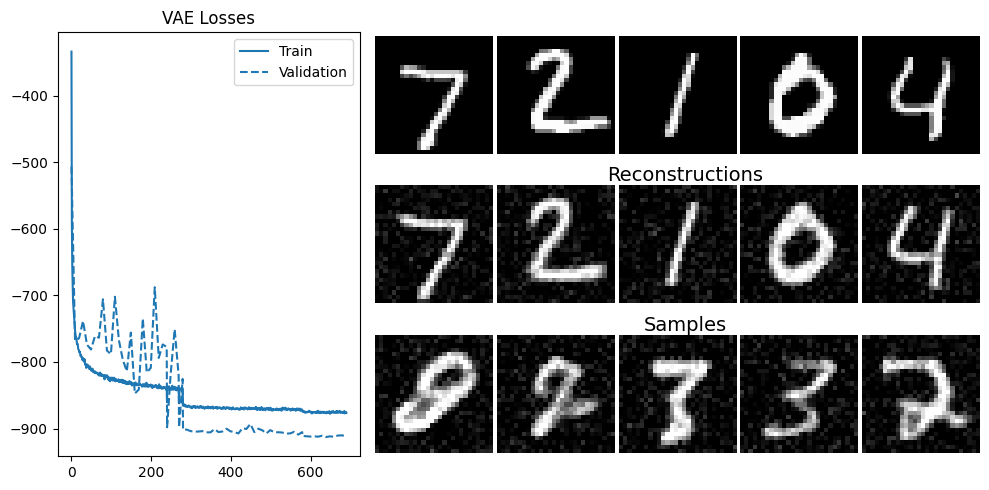

In [35]:
# %%time
def visualize_training(n_epochs=300):
    plot_interval = 10
    metric = CoordinateDistributionMetric(TotalVariation1d(), projection_coordinates=(0,1))
    models = [
        ('VAE', vae, vae_trainer, 'tab:blue'),
#        ('Flow', flow, flow_trainer, 'tab:orange')
    ]
    n_models = len(models)
    #for _, _, trainer, _ in models:
    #    trainer.clear_loss_history()
    
    test_logs = defaultdict(list)

    def plot_statistic(self, model_id, statistic_name, *args, **kwargs):
        model_name, _, _, color = models[model_id]
        statistic = test_logs[model_name + '_' + statistic_name]
        return self.plot(np.arange(1, len(statistic)+1), statistic, c=color, *args, **kwargs)
    mpl.axes.Axes.plot_statistic = plot_statistic
        
    
    vae.train()
    # flow.train()

    '''with torch.profiler.profile(
        # schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('../log/vae_mnist_training'),
        record_shapes=False,
        profile_memory=False,
        with_stack=True
    ) as prof:'''

    for epoch_idx in range(1, n_epochs + 1):
        #for g in vae_trainer.optimizer.param_groups:
        #    g['lr'] = 1e-4
        is_display_epoch = epoch_idx == 1 or epoch_idx % plot_interval == 0
        
        for model_name, model, trainer, color in models:
            trainer.run_classic_epoch(train_loader, val_loader if is_display_epoch else None)    

        if is_display_epoch:
            clear_output(wait=True)
            fig = plt.figure(figsize=(10, 5))
            gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
            
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.set_title(f'{models[0][0]} Losses')
            ax1.plot(*models[0][2].get_loss_history(train=True), label='Train', color=models[0][3])
            ax1.plot(*models[0][2].get_loss_history(train=False), label='Validation', linestyle='--', color=models[0][3])
            ax1.legend()
            
            gs_right = gridspec.GridSpecFromSubplotSpec(3, n_display_imgs, subplot_spec=gs[0, 1])
            fig.text(0.69, 0.64, "Reconstructions", fontsize=14, ha="center", va="center")
            fig.text(0.69, 0.34, "Samples", fontsize=14, ha="center", va="center")
            vae.eval()
            with torch.no_grad():
                display_img_reconstructions = vae.reconstruct(display_imgs.to(device)).to('cpu')
                sample_imgs = vae.sample((n_display_imgs,)).to('cpu')
            imgs_to_plot = torch.stack((display_imgs, display_img_reconstructions, sample_imgs))
            vae.train()
            for i in range(3):
                for j in range(n_display_imgs):
                    ax = fig.add_subplot(gs_right[i, j])
                    ax.imshow(imgs_to_plot[i][j][0], cmap='gray', vmin=-1, vmax=1)
                    ax.axis('off')
            
            plt.tight_layout()         
            plt.show()
    
    vae.eval()
    # flow.eval()

visualize_training(n_epochs=1)

In [19]:
for param_name, param in vae.named_parameters():
    print(f'{param_name}: {torch.numel(param)}')
print(f'Total: {sum([torch.numel(param) for param in vae.parameters()])}')

decoder_log_var: 1
encoder.0.weight: 288
encoder.0.bias: 32
encoder.1.weight: 32
encoder.1.bias: 32
encoder.4.weight: 9216
encoder.4.bias: 32
encoder.5.weight: 32
encoder.5.bias: 32
encoder.8.weight: 9216
encoder.8.bias: 32
encoder.9.weight: 32
encoder.9.bias: 32
encoder.13.weight: 9216
encoder.13.bias: 32
decoder.0.weight: 4608
decoder.0.bias: 288
decoder.1.weight: 288
decoder.1.bias: 288
decoder.5.weight: 9216
decoder.5.bias: 32
decoder.6.weight: 32
decoder.6.bias: 32
decoder.9.weight: 9216
decoder.9.bias: 32
decoder.10.weight: 32
decoder.10.bias: 32
decoder.13.weight: 288
decoder.13.bias: 1
Total: 52642


In [26]:
ebm_im_sz = 32
img_upsampler = torch.nn.Upsample(size=ebm_im_sz)
target = MnistEBMDistribution(device=device)
sampled_imgs = vae.sample((5,))
print(img_upsampler(sampled_imgs).shape)
print(noise_imgs.shape)
noise_imgs = 2 * torch.rand((n_display_imgs, 1, ebm_im_sz, ebm_im_sz), device=device) - 1
print('Real digit log-likelihoods:', target.log_prob(img_upsampler(display_imgs).to(device)))
print('Sampled digit log-likelihoods:', target.log_prob(img_upsampler(sampled_imgs)))
print('Uniform noise log-likelihoods:', target.log_prob(noise_imgs))

torch.Size([5, 1, 32, 32])
torch.Size([5, 1, 32, 32])
Real digit log-likelihoods: tensor([-0.0224, -0.0350, -0.0146, -0.0335, -0.0231], device='cuda:0')
Sampled digit log-likelihoods: tensor([-0.4100, -0.4185, -0.4274, -0.4142, -0.3943], device='cuda:0')
Uniform noise log-likelihoods: tensor([-2.6826, -2.7218, -2.7006, -2.7424, -2.6313], device='cuda:0')


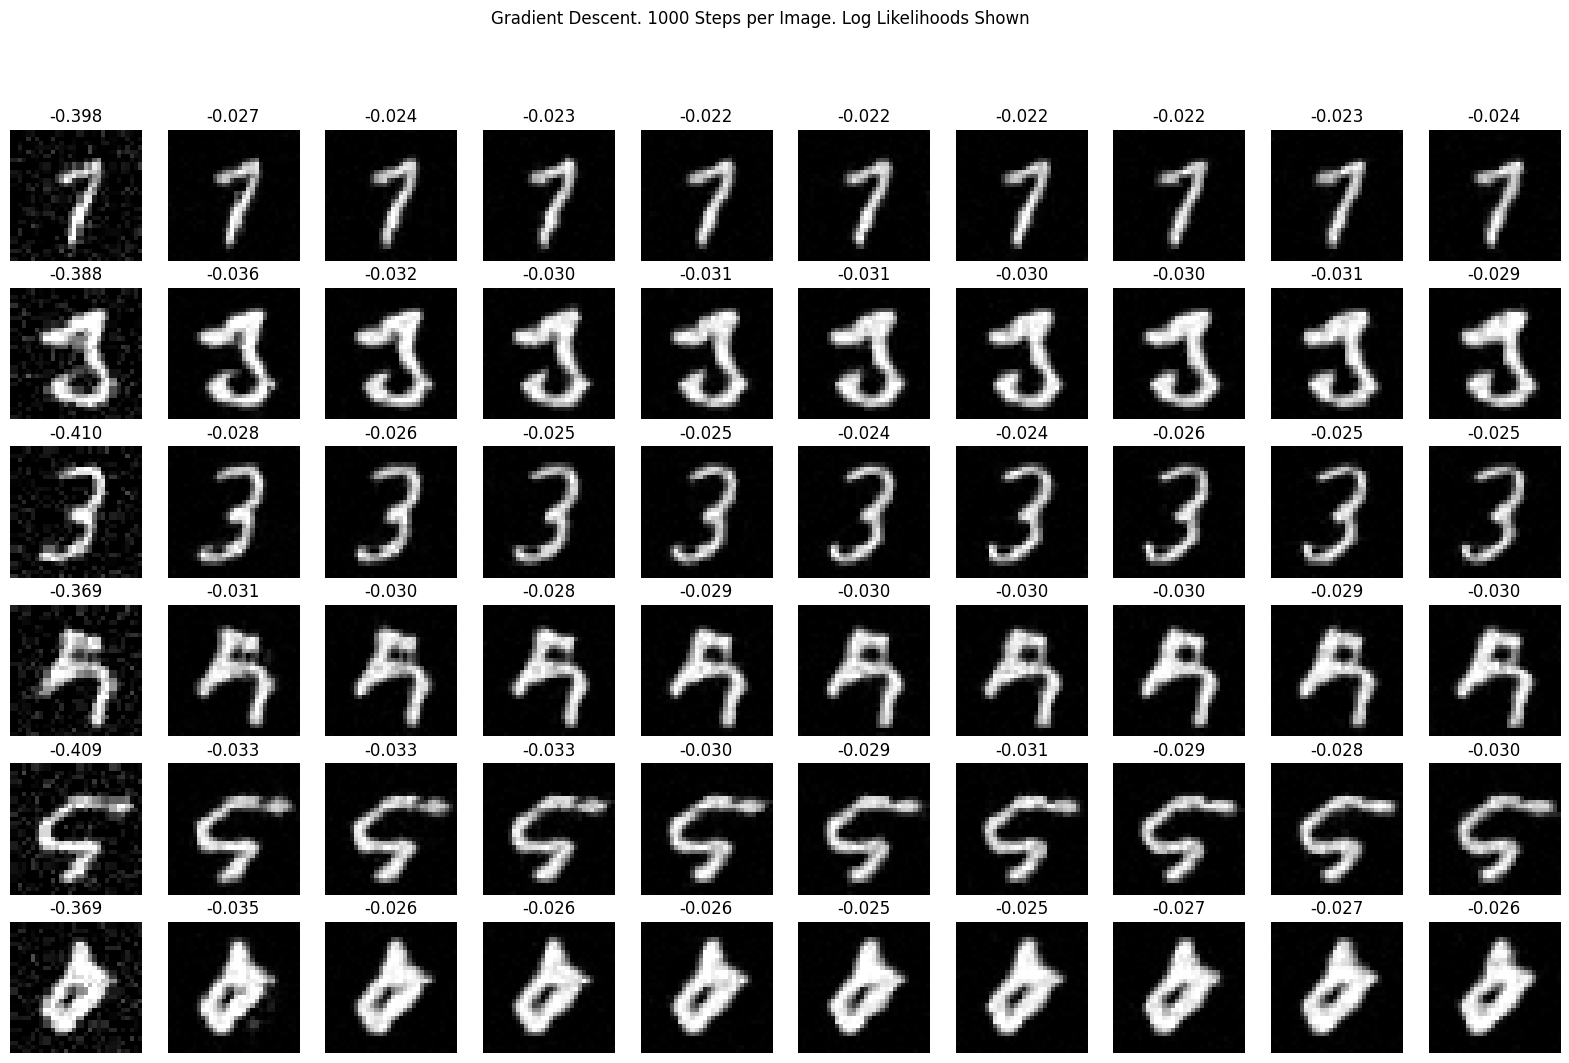

In [33]:
def sample_ebm_ula(images_in_chain=10, n_chains=6, steps_per_image=1_000, step_size=1):
    #chain_states = 2 * torch.rand((n_chains, 1, ebm_im_sz, ebm_im_sz), device=device) - 1
    chain_states = img_upsampler(vae.sample((n_chains,)))
    torch.cuda.empty_cache()
    #chain_states = (train_dataset.tensor[:n_chains]).clone().to(device)
    #chain_states += torch.randn_like(chain_states) * 1  # torch.linspace(0.01, 1, n_chains, device=device)[:, None, None, None]
    result = [chain_states.clone()]
    chain_states.requires_grad_()
    for step in range((images_in_chain - 1) * steps_per_image):
        log_likelihood_gradients = torch.autograd.grad(target.log_prob(chain_states).sum(), [chain_states])[0]
        chain_states.detach_().requires_grad_()
        with torch.no_grad():
            chain_states.add_(step_size * log_likelihood_gradients + 7.5e-3 * torch.randn_like(chain_states))
        if (step + 1) % steps_per_image == 0:
           result.append(chain_states.clone().detach())

    fig, axs = plt.subplots(ncols=images_in_chain, nrows=n_chains, figsize=(20, 12))
    fig.suptitle(f'Gradient Descent. {steps_per_image} Steps per Image. Log Likelihoods Shown')
    for i in range(images_in_chain):
        log_probs = target.log_prob(result[i])
        for j in range(n_chains):
            axs[j][i].imshow(result[i][j][0].to('cpu'), cmap='gray', vmin=-1, vmax=1)
            axs[j][i].axis('off')
            axs[j][i].set_title(f'{log_probs[j].item():0.3f}')

sample_ebm_ula()

In [34]:
SAVE_KNOWLEDGE = False
if SAVE_KNOWLEDGE:
    vae.save_knowledge('../models/mnist_convvae_latent_16')